### Image classification Using CNN

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
# Count the number of images in the directory specified by data_dir and print the count

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


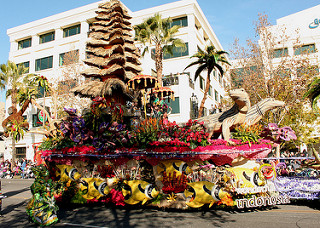

In [5]:
# Retrieve the file paths of the images in the roses subdirectory and display the first two images

roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[7]))

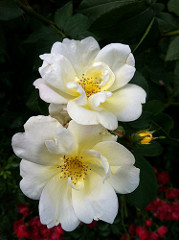

In [6]:
PIL.Image.open(str(roses[0]))

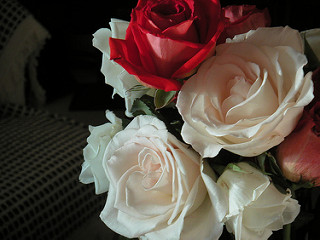

In [7]:
PIL.Image.open(roses[1])

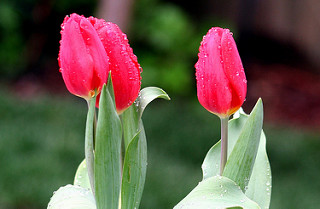

In [8]:
# Retrieve the file paths of the images in the tulips subdirectory and display the first image

tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(tulips[0])

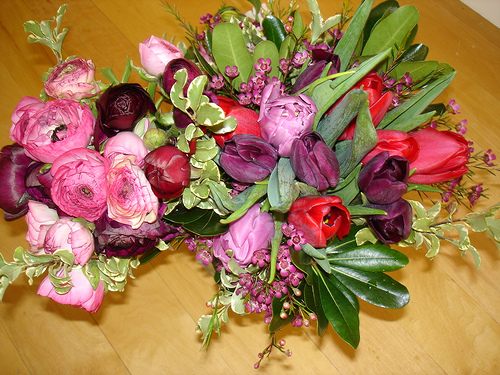

In [9]:
PIL.Image.open(tulips[10])

#### Creating a Training Dataset

### Creating a Training Dataset
- Set the batch size, image height, and image width variables
- Create a training dataset using **tf.keras.utils.image_dataset_from_directory()** function, passing the following parameters:
  - __data_dir:__ The directory containing the image dataset
  - **validation_split**: The fraction of data to reserve for validation
  - **subset**: Specify the subset of the dataset to use (in this case, training)
  - **seed**: Random seed for shuffling the data
  - **image_size**: The desired size for the images in the dataset
  - **batch_size**: The number of samples per batch

In [10]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                      validation_split=0.2,
                                                      subset='training',
                                                      seed=123,
                                                      image_size=(img_height, img_width),
                                                      batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


### Creating a Validation Dataset
- Create a validation dataset using **tf.keras.utils.image_dataset_from_directory()** function, passing the following parameters:
  - __data_dir:__ The directory containing the image dataset
  - **validation_split**: The fraction of data to reserve for validation
  - **subset**: Specify the subset of the dataset to use (in this case, validation)
  - **seed**: Random seed for shuffling the data
  - **image_size**: The desired size for the images in the dataset
  - **batch_size**: The number of samples per batch

In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                    validation_split=0.2,
                                                    subset='validation',
                                                    seed = 123,
                                                    image_size=(img_height, img_width),
                                                    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


### Visualizing a Subset of Images from the Training Dataset
- Obtain the class names from the train_ds dataset using the class_names attribute
- Print the **class_names** to display the list of class labels
- Import the **matplotlib.pyplot** module for visualization purposes
- Create a figure with a size of 10x10 using **plt.figure(figsize=(10, 10))**
- Iterate over the first batch of images and labels in the **train_ds** dataset using **train_ds.take(1)**
- For each image in the batch (up to 9 images), create a subplot using **plt.subplot(3, 3, i + 1)**
- Display the image using **plt.imshow(images[i].numpy().astype("uint8"))**
- Set the title of the subplot to the corresponding class name using **plt.title(class_names[labels[i]])**
- Disable the axis labels for the subplot using __plt.axis("off")__

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


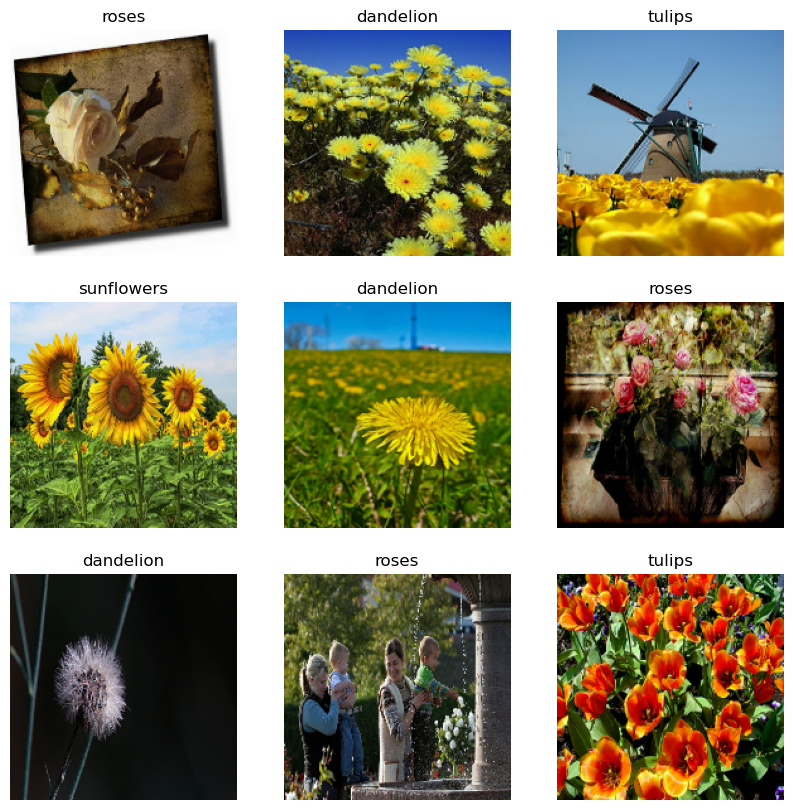

In [13]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

### Preprocessing and Normalizing the Training Dataset
- Set the value of **AUTOTUNE** to **tf.data.AUTOTUNE**
- Cache the **train_ds** dataset for improved performance by calling the **cache()** method
- Shuffle the elements of the **train_ds** dataset using a buffer size of **1000** by calling the **shuffle()** method
- Prefetch the elements of the **train_ds** dataset for improved performance by calling the **prefetch()** method with **buffer_size=AUTOTUNE**
- Cache the **val_ds** dataset for improved performance by calling the **cache()** method
- Prefetch the elements of the **val_ds** dataset for improved performance by calling the **prefetch()** method with **buffer_size=AUTOTUNE**
- Create a __Rescaling__ layer to normalize the pixel values of the dataset images to the range **[0, 1]**
- Apply the __normalization_layer__ to the **train_ds** dataset using the **map()** method and **lambda** function
- Retrieve a batch of images and labels from the normalized dataset using next**(iter(normalized_ds))**
- Access the first image in the batch using **image_batch[0]**
- Print the minimum and maximum pixel values of the first image using **np.min(first_image)** and __np.max(first_image)__


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# Create a Rescaling layer to normalize the pixel values of the dataset images to the range [0, 1]
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.0 0.99970955


### Creating a Convolutional Neural Network Model With Data Augmentation
- Create a data augmentation pipeline using **keras.Sequential** with three augmentation layers: random horizontal flip, random rotation, and random zoom
- Determine the number of classes based on the **class_names**

In [16]:
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal', input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),])

- Create a sequential model with data augmentation as the first layer and rescaling layer.
- Add convolutional layers with an increasing number of filters, 3x3 kernel, padding, and ReLU activation.
- Add max pooling layers after each convolutional layer.
- Add a dropout layer with a rate of **0.2**.
- Add dense layers with ReLU activation, ending with a dense output layer.

In [17]:
num_classes = len(class_names)
model = Sequential([data_augmentation,
                    layers.Rescaling(1./255),
                    layers.Conv2D(64,3, padding = 'same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(32,3, padding = 'same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(16,3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Dropout(0.2),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(num_classes)
                   ])

In [18]:
# Display the summary of the model architecture and the number of parameters

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                 

In [19]:
# Compile the model with the specified optimizer, loss function, and metrics

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [20]:
# Train the model and set epochs to 5

epochs = 3
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5


92/92 [==============================] - 227s 2s/step - loss: 1.3283 - accuracy: 0.4295 - val_loss: 1.1178 - val_accuracy: 0.5559
Epoch 2/5
92/92 [==============================] - 218s 2s/step - loss: 1.0915 - accuracy: 0.5579 - val_loss: 1.0486 - val_accuracy: 0.5777
Epoch 3/5
92/92 [==============================] - 218s 2s/step - loss: 1.0027 - accuracy: 0.6141 - val_loss: 0.9842 - val_accuracy: 0.5995
Epoch 4/5
92/92 [==============================] - 213s 2s/step - loss: 0.9401 - accuracy: 0.6301 - val_loss: 0.8995 - val_accuracy: 0.6431
Epoch 5/5
92/92 [==============================] - 216s 2s/step - loss: 0.8537 - accuracy: 0.6761 - val_loss: 0.8413 - val_accuracy: 0.6812


### Visualizing the Result
- Retrieve the accuracy and loss values from the training history
- Create a range of epochs
- Plot the training and validation accuracy in a subplot
- Plot the training and validation loss in a subplot
- Display the plotted figures

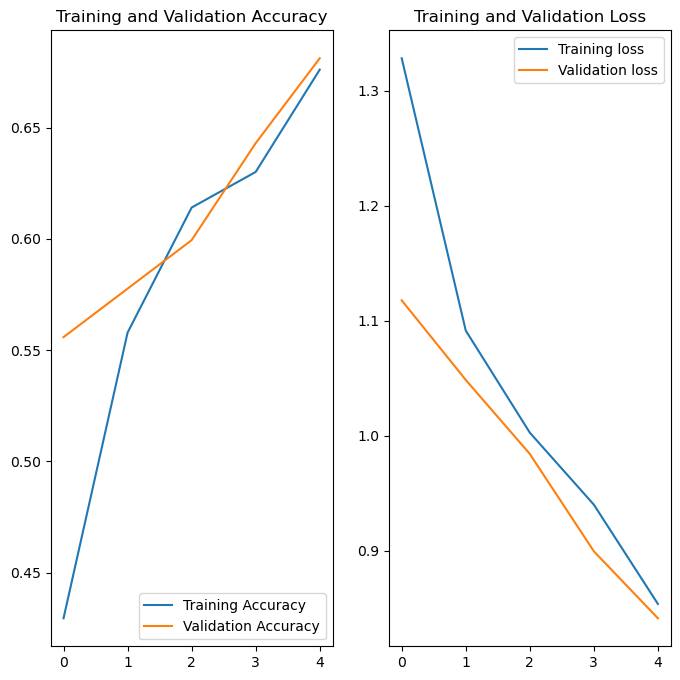

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label = 'Validation loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predicting the Class of a Given Image
- Define the URL of the image and download it using **tf.keras.utils.get_file()**
- Load the image and resize it to the desired target size
- Convert the image to an array and expand its dimensions to create a batch
- Make predictions on the image using the trained model
- Calculate the softmax scores and identify the class with the highest confidence
- Print the predicted class and its corresponding confidence percentage

In [22]:
sunflower_url = '"https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg'
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(sunflower_path,
                             target_size=(img_height, img_width))

In [23]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

In [24]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("This image most likely belongs to {} with a {:.2f} percent confidence."
     .format(class_names[np.argmax(score)], 100*np.max(score)))

1/1 [==============================] - 1s 651ms/step
This image most likely belongs to sunflowers with a 66.08 percent confidence.
